# EXPLAINABLE MACHINE LEARNING

@Author Gabriel Schurr, Ilyesse Hettenbach

### IMPORTS

In [ ]:
import os
import random
import re
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

from torch_utils import get_loaders, transform

load_dotenv()

In [ ]:
DATAPATH = str(os.getenv("ANOMALYDATAPATH"))

train_label_paths = []
test_label_paths = []

for _path in os.walk(DATAPATH):
    if _path[0].endswith("Train"):
        _path = _path[0]
        _path = os.path.join(_path, "Label", "Labels.txt")
        train_label_paths.append(_path)
    elif _path[0].endswith("Test"):
        _path = _path[0]
        _path = os.path.join(_path, "Label", "Labels.txt")
        test_label_paths.append(_path)

train_labels = dict()

for l in train_label_paths:
    with open(l, "r") as f:
        label_lines = f.readlines()

    label_lines = [l.strip().replace('\t', ' ') for l in label_lines][1:]
    for line in label_lines:
        _img = str(line.split()[2])
        base_path = os.path.abspath(os.path.join(l, os.pardir, os.pardir))
        _img = os.path.join(base_path, _img)
        _label = int(line.split()[1])
        train_labels[_img] = _label

test_labels = dict()

for l in test_label_paths:
    with open(l, "r") as f:
        label_lines = f.readlines()

    label_lines = [l.strip().replace('\t', ' ') for l in label_lines][1:]
    for line in label_lines:
        _img = str(line.split()[2])
        base_path = os.path.abspath(os.path.join(l, os.pardir, os.pardir))
        _img = os.path.join(base_path, _img)
        _label = int(line.split()[1])
        test_labels[_img] = _label

In [ ]:
train_df = pd.DataFrame.from_dict(train_labels, orient='index', columns=['label'])
test_df = pd.DataFrame.from_dict(test_labels, orient='index', columns=['label'])

# drop samples to balance the dataset
value_counts = train_df['label'].value_counts()
min_value = min(value_counts)
max_value = max(value_counts)
kept_df = train_df[train_df['label'] == 0].sample(n=min_value, random_state=42)
# Concatenate the sampled data with samples from other classes
train_df = pd.concat([kept_df, train_df[train_df['label'] == 1]], axis=0)

# drop samples to balance the dataset
value_counts = test_df['label'].value_counts()
min_value = min(value_counts)
max_value = max(value_counts)
kept_df = test_df[test_df['label'] == 0].sample(n=min_value, random_state=42)
# Concatenate the sampled data with samples from other classes
test_df = pd.concat([kept_df, test_df[test_df['label'] == 1]], axis=0)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = 'cpu'

BATCH_SIZE = 16
EPOCHS = 15
LR = 0.0001
RANDOM_SEED = 42
NUM_WORKERS = 6

print(f"Device: {DEVICE}")

In [ ]:
do_train = False
do_checkpoint = False
do_load_model = True
model_path = "best_model_anomaly.pth"

### EDA

In [83]:
train_df.head()

label
F:\BIG_FILES\AI_DATA\WeaklySupervisedAnomalyDet...      0
F:\BIG_FILES\AI_DATA\WeaklySupervisedAnomalyDet...      0
F:\BIG_FILES\AI_DATA\WeaklySupervisedAnomalyDet...      0
F:\BIG_FILES\AI_DATA\WeaklySupervisedAnomalyDet...      0
F:\BIG_FILES\AI_DATA\WeaklySupervisedAnomalyDet...      0

In [82]:
train_df.describe()

label
count  2092.00000
mean      0.50000
std       0.50012
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000

C:\Users\gabri\AppData\Local\Temp\ipykernel_11672\1792813042.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = train_df['label'][random_index]


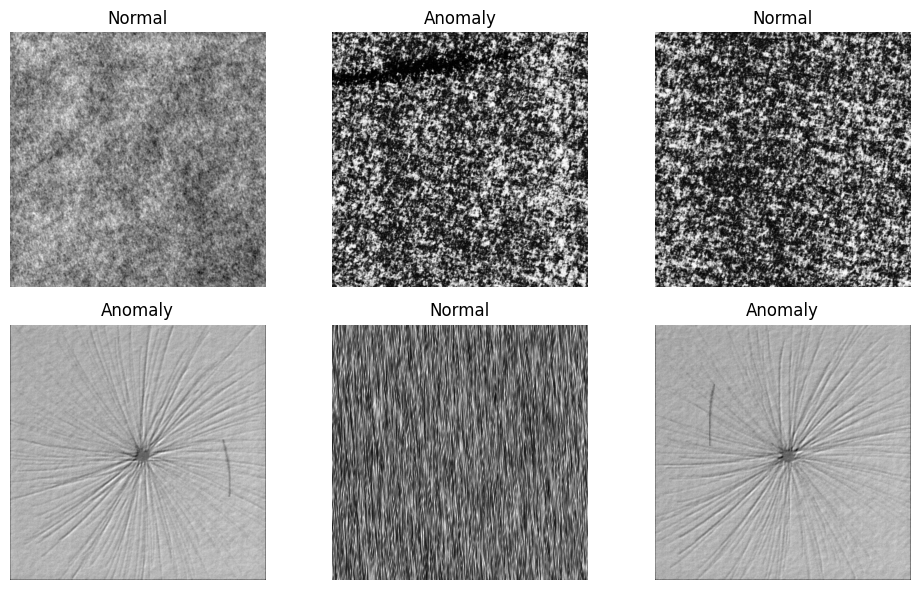

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    random_index = random.randint(0, len(train_df)-1)
    img = Image.open(train_df.index[random_index]).convert('RGB')
    label = train_df['label'][random_index]
    label = 'Normal' if label == 0 else 'Anomaly'
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

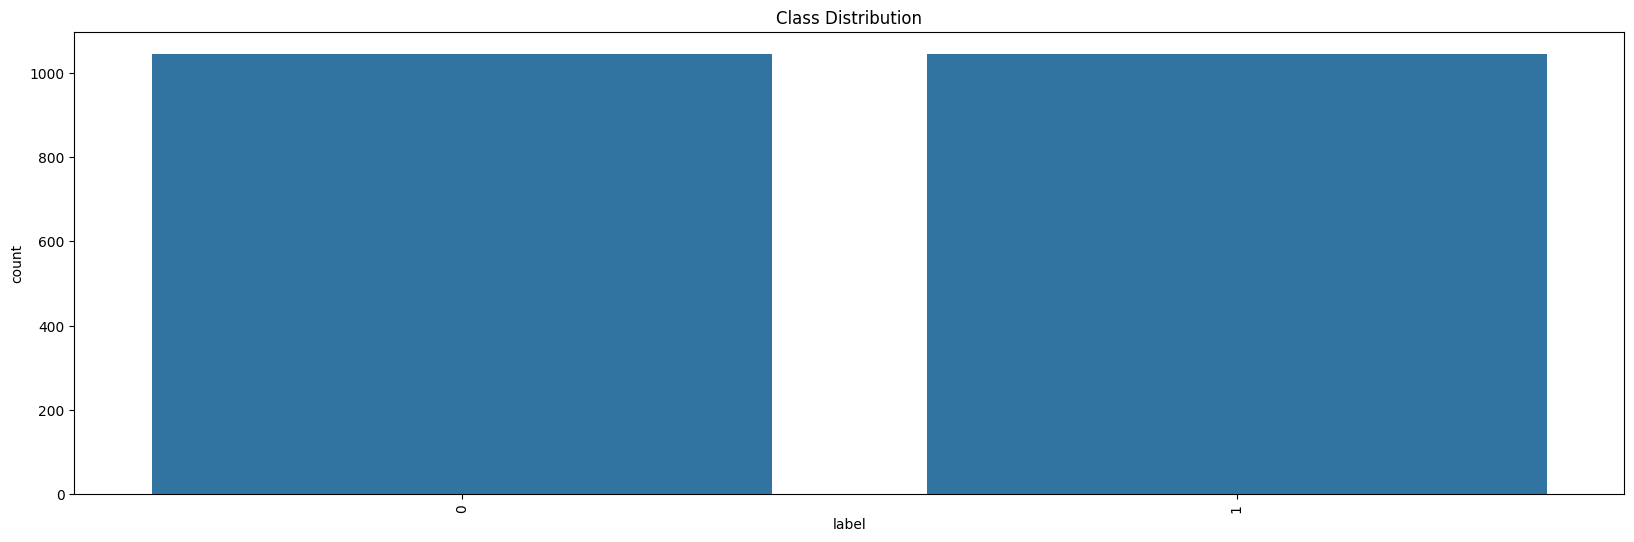

In [80]:
# Visualize class distribution
plt.figure(figsize=(20, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

In [ ]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet

### MODEL

In [ ]:

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet18, self).__init__()
        self.output = None
        self.resnet = models.resnet18(weights='IMAGENET1K_V1') # 'IMAGENET1K_V1'
        # for param in self.resnet.parameters():
        #     param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        self.output = self.resnet(x)
        return self.output

    def freeze_backbone(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        for param in self.resnet.parameters():
            param.requires_grad = True

model = CustomResNet18()
if do_load_model and os.path.exists(model_path):
    model = torch.load(model_path)
    print("Model loaded")

summary(model, (3, 224, 224), device="cpu")

In [ ]:
train_loader, val_loader = get_loaders(train_df, test_df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, load_anomaly=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

### TRAINING

In [ ]:
if do_train:
    model.train().to(DEVICE)
    train_losses = []
    train_accs = []
    with tqdm(total=EPOCHS, desc='Training') as pbar:
        for epoch in range(1, EPOCHS+1):
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                idx, inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_losses.append(loss.item())
                train_accs.append((outputs.argmax(1) == labels).float().mean().item())
                pbar.set_postfix({'batch': f'{i+1}/{len(train_loader)}', 'loss': f'{running_loss/(i+1):.3f}'})

            pbar.update(1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(train_losses)
    axes[0].set_title('Train Loss')
    axes[1].plot(train_accs)
    axes[1].set_title('Train Accuracy')
    plt.show()

if do_checkpoint:
    model.cpu().eval()
    torch.save(model, model_path)

### EVALUATION

In [ ]:
model.eval().to(DEVICE)
pred_data = []
with tqdm(total=len(val_loader), desc='Validation') as pbar:
    for data in val_loader:
        idx, inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(idx)):
            pred_data.append(
                {'idx': idx[i].item(),
                'pred': predicted[i].cpu().detach().item(),
                'correct': predicted[i].cpu().detach().item() == labels[i].cpu().detach().item()
                })
        pbar.update(1)

pred_df = pd.DataFrame(pred_data).set_index('idx')

In [79]:
print(f'Mean Accuracy: {pred_df["correct"].mean():.3f} on validation set')

Mean Accuracy: 0.892 on validation set


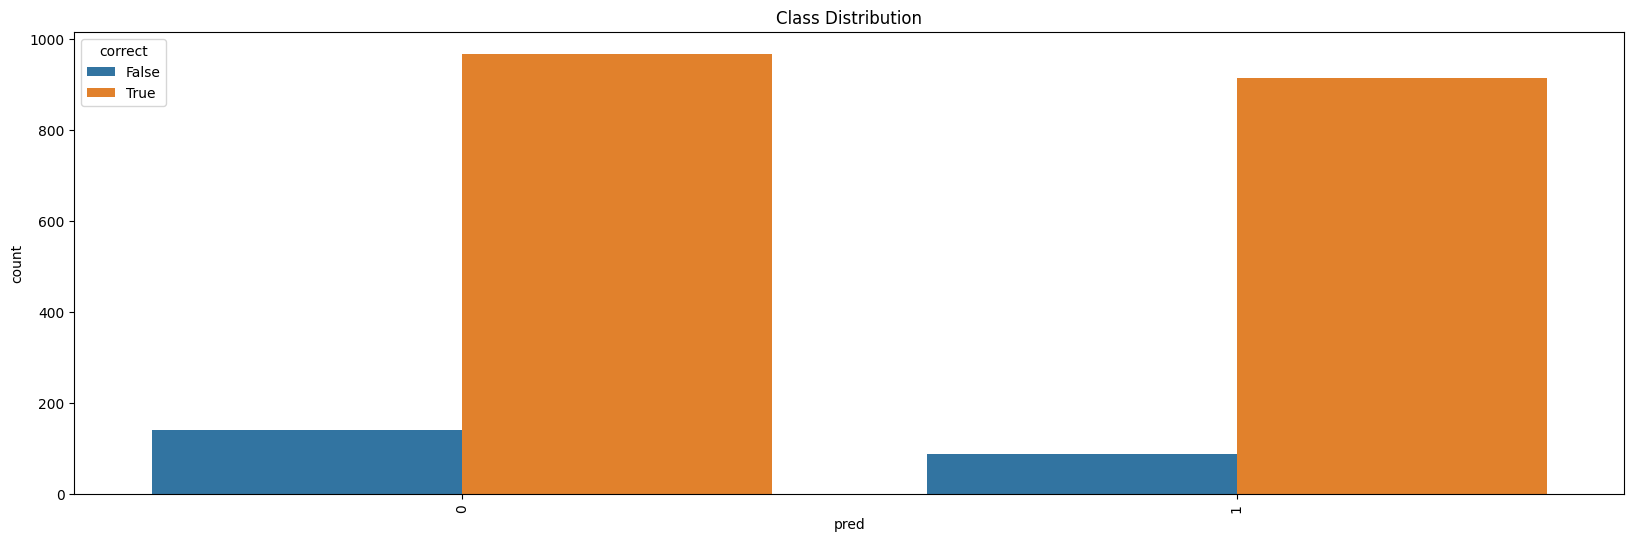

In [78]:
# Visualize per class accuracy in a bar plot with correct and false predictions
plt.figure(figsize=(20, 6))
sns.countplot(x='pred', hue='correct', data=pred_df)
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

### GRAD-CAM

The following code is used to generate the Grad-CAM visualizations for the model. This technique is used to visualize the areas of the image that the model is focusing on when making a prediction. This is done by using the gradients of the model to generate a heatmap of the image. The heatmap is then superimposed on the original image to show the areas of the image that the model is focusing on.

In [77]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def plot_grad_cam(model, img_path, transform, image_weight=0.5, device='cpu', targets=None):
    target_layers = model.resnet.layer4
    model = model.to(device)
    model.unfreeze_backbone()
    use_cuda = True if 'cuda' in str(device) else False

    original_image = Image.open(img_path).convert('RGB')
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    pred = model(input_tensor)
    pred_class_idx = pred.argmax(1).item()
    pred_prob = pred.softmax(1)[0, pred_class_idx].item()

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(targets)] if targets is not None else targets
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam = cv2.resize(grayscale_cam, (original_image.size[0], original_image.size[1]))

    np_image = np.array(original_image).astype(np.float32) / 255.0
    np_image = np_image - np.min(np_image)
    np_image = np_image / np.max(np_image)

    visualization = show_cam_on_image(np_image, grayscale_cam, use_rgb=True, image_weight=image_weight)
    visualization = Image.fromarray(visualization)

    return visualization, pred_class_idx, pred_prob

Predicted: Normal (0.606)
True: Anomaly


C:\Users\gabri\AppData\Local\Temp\ipykernel_11672\1332976026.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = sample_from_test['label'][0]


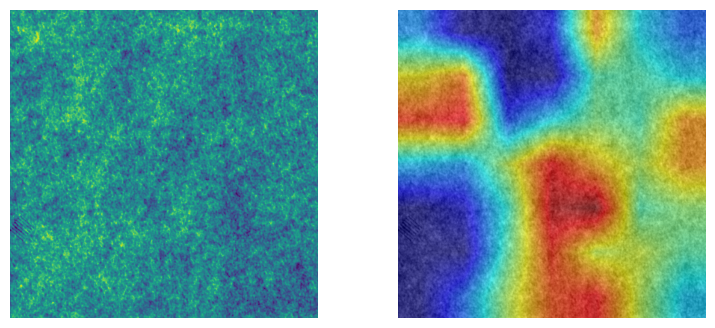

In [76]:
sample = pred_df[pred_df['correct'] == False].sample(1)
sample_from_test = test_df.iloc[sample.index]
img_path = sample_from_test.index[0]
true_label = sample_from_test['label'][0]
image = Image.open(img_path)
image_size = image.size
visualization, _pred, pred_prob = plot_grad_cam(model, img_path, transform, device=DEVICE, image_weight=0.4)
_pred = 'Normal' if _pred == 0 else 'Anomaly'
true_label = 'Normal' if true_label == 0 else 'Anomaly'
visualization = visualization.resize(image_size)
print(f'Predicted: {_pred} ({pred_prob:.3f})')
print(f'True: {true_label}')
plt.figure(figsize=(10, 4))
# distance between subplots
plt.subplots_adjust(wspace=0.0001)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.axis('off')
plt.show()

**True Predictions**

In the following we will show a few examples of correctly classified images and their corresponding Grad-CAM heatmaps.

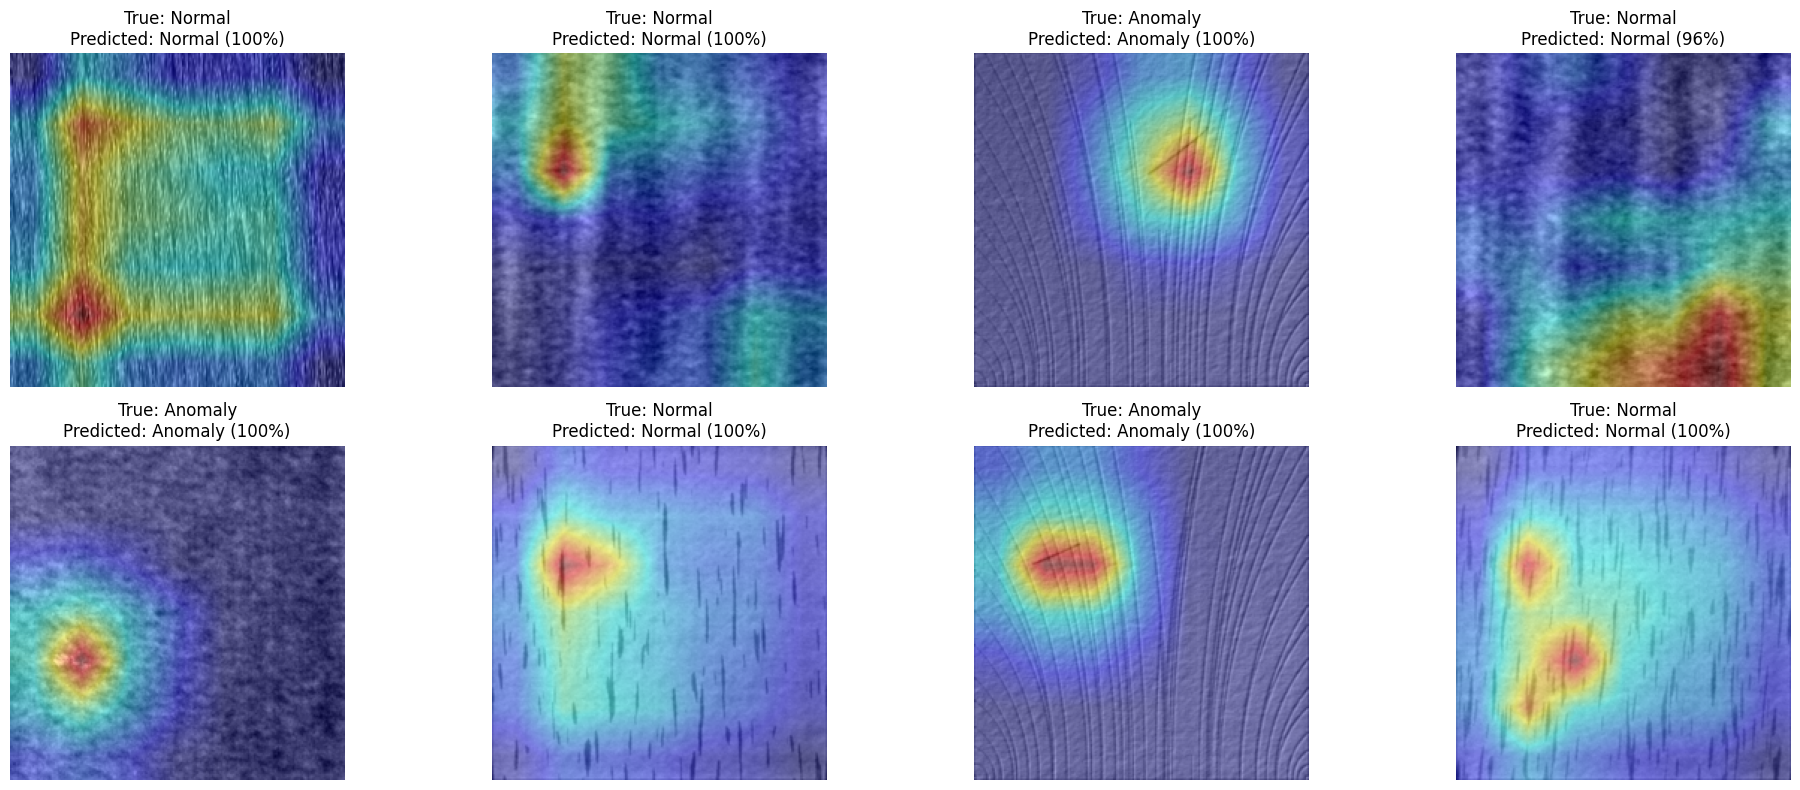

In [75]:
images_to_show = 8
images_per_row = 4
cols = images_to_show // images_per_row
fig, axes = plt.subplots(cols, images_per_row, figsize=(20, 4*cols))

samples = pred_df[pred_df['correct'] == True].sample(images_to_show, random_state=24)

for i, sample in enumerate(samples.iterrows()):
    sample_from_test = test_df.iloc[[sample[0]]]
    img_path = sample_from_test.index.values[0]
    true_label = sample_from_test['label'].values[0]
    true_label = 'Normal' if true_label == 0 else 'Anomaly'
    visualization, pred, pred_prob = plot_grad_cam(model, img_path, transform, device=DEVICE, image_weight=0.6)
    pred = 'Normal' if pred == 0 else 'Anomaly'
    visualization = visualization.resize((224, 224))
    axes[i//images_per_row, i%images_per_row].imshow(visualization)
    axes[i//images_per_row, i%images_per_row].set_title(f'True: {true_label}\nPredicted: {pred} ({pred_prob*100:.0f}%)')
    axes[i//images_per_row, i%images_per_row].axis('off')
plt.tight_layout()
plt.show()

**False Predictions**

In the following we will take a look at a few false predictions of our model. To explain the false prediction, we will use the Grad-CAM algorithm. With that approach we can visualize the regions of the image that were most important for the model to make its prediction.

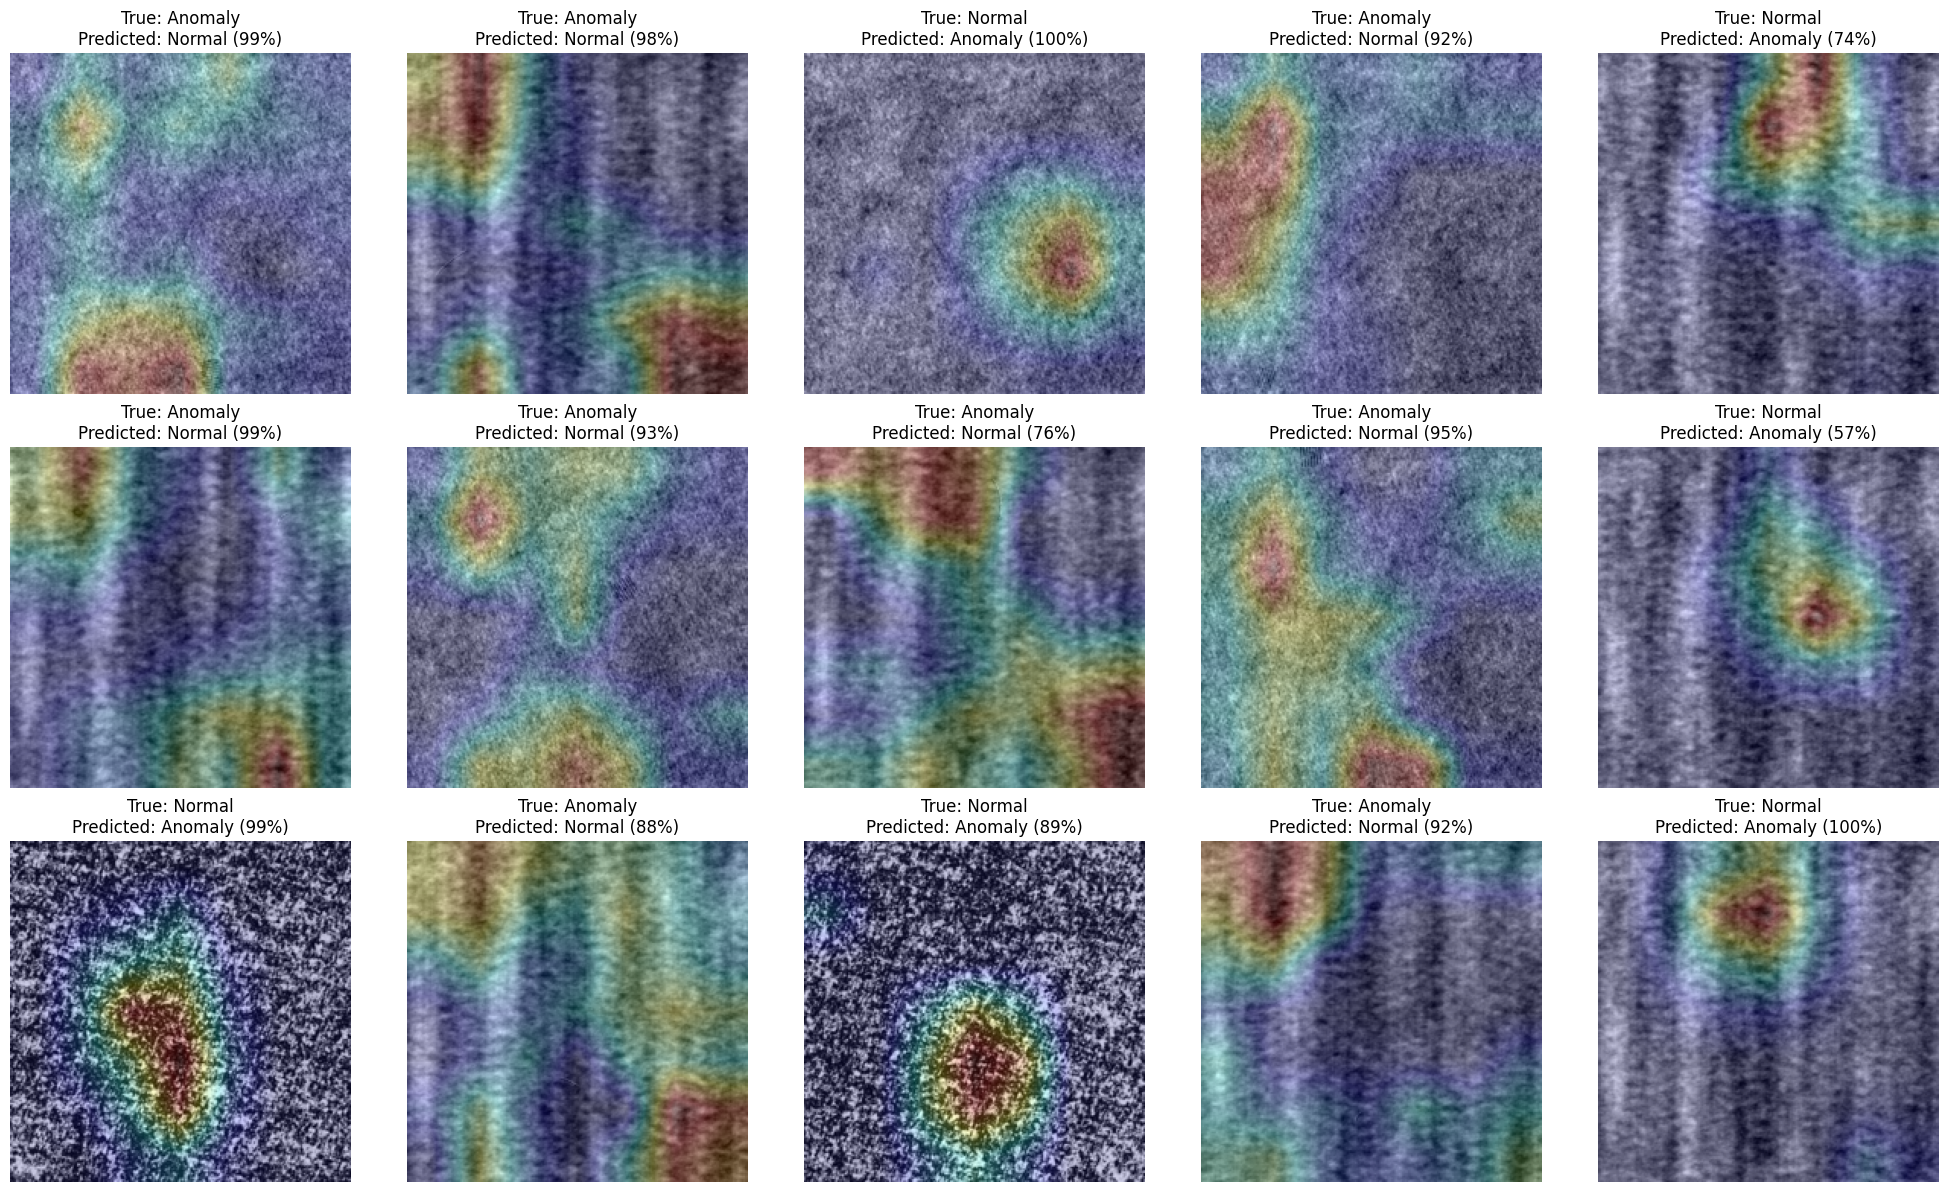

In [74]:
images_to_show = 15
images_per_row = 5
cols = images_to_show // images_per_row
fig, axes = plt.subplots(cols, images_per_row, figsize=(20, 4*cols))

samples = pred_df[pred_df['correct'] == False].sample(images_to_show, random_state=38)

for i, sample in enumerate(samples.iterrows()):
    sample_from_test = test_df.iloc[[sample[0]]]
    img_path = sample_from_test.index.values[0]
    true_label = sample_from_test['label'].values[0]
    true_label = 'Normal' if true_label == 0 else 'Anomaly'
    visualization, pred, pred_prob = plot_grad_cam(model, img_path, transform, device=DEVICE, image_weight=0.8)
    pred = 'Normal' if pred == 0 else 'Anomaly'
    visualization = visualization.resize((224, 224))
    axes[i//images_per_row][i%images_per_row].imshow(visualization)
    axes[i//images_per_row][i%images_per_row].set_title(f'True: {true_label}\nPredicted: {pred} ({pred_prob*100:.0f}%)')
    axes[i//images_per_row][i%images_per_row].axis('off')
plt.tight_layout()
plt.show()

In [73]:
def visualize_side_by_side(model, samples, transform, device, image_weight=0.6):
    sample_from_test = test_df.iloc[samples.index]
    img_path = sample_from_test.index.values[0]
    true_label = sample_from_test['label'].values[0]
    true_label = 'Normal' if true_label == 0 else 'Anomaly'

    image = Image.open(img_path)
    image_size = image.size

    visualization, pred, pred_prob = plot_grad_cam(model, img_path, transform, device=device, image_weight=image_weight)
    pred = 'Normal' if pred == 0 else 'Anomaly'
    visualization = visualization.resize(image_size)

    print(f'Predicted: {pred} ({pred_prob:.3f})')
    print(f'True: {true_label}')

    plt.figure(figsize=(8, 3))
    concatenated_image = Image.new('RGB', (image_size[0]*2, image_size[1]))
    concatenated_image.paste(image, (0, 0))
    concatenated_image.paste(visualization, (image_size[0], 0))

    plt.imshow(concatenated_image)
    plt.axis('off')
    plt.show()

### Side-by-Side Comparison

#### True Predictions

Predicted: Anomaly (0.997)
True: Anomaly


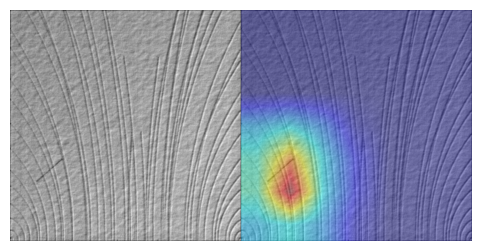

Predicted: Normal (1.000)
True: Normal


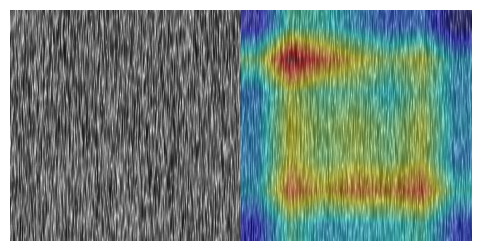

Predicted: Anomaly (1.000)
True: Anomaly


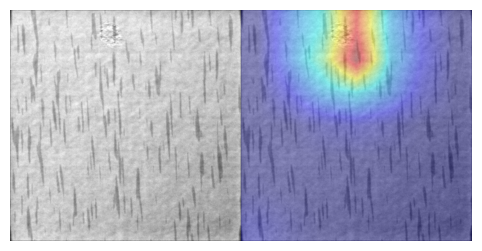

Predicted: Anomaly (1.000)
True: Anomaly


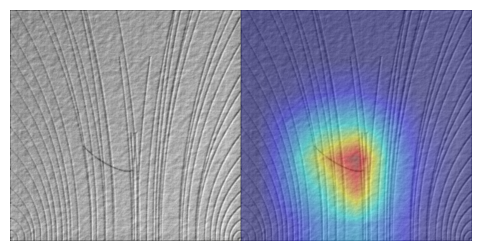

In [71]:
# 1043, 7348, 1714, 8989
samples = pred_df[pred_df['correct'] == True].sample(1, random_state=1043)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.6)

samples = pred_df[pred_df['correct'] == True].sample(1, random_state=7348)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.6)

samples = pred_df[pred_df['correct'] == True].sample(1, random_state=1714)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.6)

samples = pred_df[pred_df['correct'] == True].sample(1, random_state=8989)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.6)

#### False Predictions

Predicted: Anomaly (0.864)
True: Normal


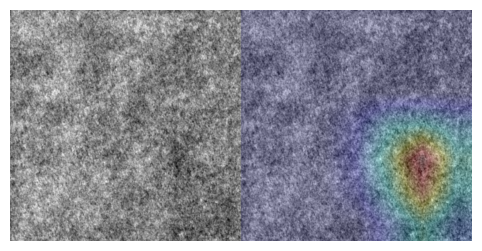

Predicted: Normal (0.996)
True: Anomaly


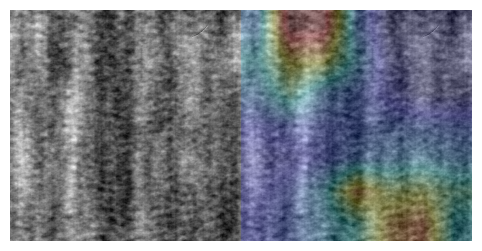

In [72]:
# 1613, 5141
samples = pred_df[pred_df['correct'] == False].sample(1, random_state=1613)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.8)

samples = pred_df[pred_df['correct'] == False].sample(1, random_state=5141)
visualize_side_by_side(model, samples, transform, device=DEVICE, image_weight=0.8)